In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyuvdata

In [53]:
wedge_slope_factor_inner=0.23
wedge_slope_factor_outer=0.7
wedge_delay_buffer=6.5e-8
wedge_variance_inner=1084.9656666412166
wedge_variance_outer=28.966173241799588
window_min_variance=5.06396954e-01
window_exp_amp=1.19213736e03
window_exp_width=6.93325643e-08
oversample_factor=16.
c = 3.0 * 10**8  # Speed of light
oversample_factor=128

In [3]:
uv = pyuvdata.UVData()
uv.read("/Users/ruby/Astro/1061316296_small.uvfits")

In [4]:
channel_width_hz = uv.channel_width
uvw_array = uv.uvw_array
Nfreqs = uv.Nfreqs
Nbls = uv.Nbls

In [54]:
bl_lengths = np.sqrt(np.sum(uvw_array**2.0, axis=1))
delay_array = np.fft.fftfreq(Nfreqs*int(oversample_factor), d=channel_width_hz)

exp_function = (
    window_exp_amp * np.exp(-np.abs(delay_array) / window_exp_width / 2)
    + window_min_variance
)
exp_function[
    np.where(exp_function > wedge_variance_outer)[0]
] = wedge_variance_outer

delay_weighting_inv = np.repeat(exp_function[np.newaxis, :], Nbls, axis=0)
for delay_ind, delay_val in enumerate(delay_array):
    wedge_bls_outer = np.where(
        wedge_slope_factor_outer * bl_lengths / c + wedge_delay_buffer
        > np.abs(delay_val)
    )[0]
    delay_weighting_inv[wedge_bls_outer, delay_ind] = wedge_variance_outer
    wedge_bls_inner = np.where(
        wedge_slope_factor_inner * bl_lengths / c + wedge_delay_buffer
        > np.abs(delay_val)
    )[0]
    delay_weighting_inv[wedge_bls_inner, delay_ind] = wedge_variance_inner

delay_weighting = 1.0 / delay_weighting_inv
freq_weighting = np.fft.ifft(delay_weighting, axis=1)


In [47]:
print(np.fft.fftfreq(5, d=.5))
print(np.fft.fftfreq(5*10, d=.5))
print(np.fft.fftfreq(5, d=2))

[ 0.   0.4  0.8 -0.8 -0.4]
[ 0.    0.04  0.08  0.12  0.16  0.2   0.24  0.28  0.32  0.36  0.4   0.44
  0.48  0.52  0.56  0.6   0.64  0.68  0.72  0.76  0.8   0.84  0.88  0.92
  0.96 -1.   -0.96 -0.92 -0.88 -0.84 -0.8  -0.76 -0.72 -0.68 -0.64 -0.6
 -0.56 -0.52 -0.48 -0.44 -0.4  -0.36 -0.32 -0.28 -0.24 -0.2  -0.16 -0.12
 -0.08 -0.04]
[ 0.   0.1  0.2 -0.2 -0.1]


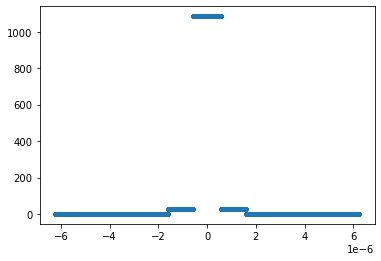

In [55]:
plt.plot(delay_array, np.abs(delay_weighting_inv[100,:]), ".")

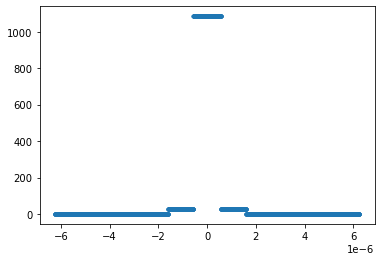

In [52]:
plt.plot(delay_array, np.abs(delay_weighting_inv[100,:]), ".")

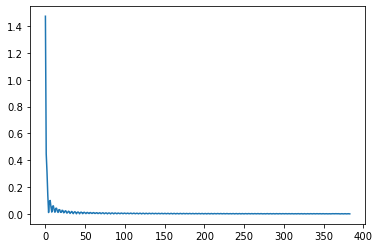

In [57]:
plt.plot(np.abs(freq_weighting[100,:Nfreqs]))

Casting complex values to real discards the imaginary part


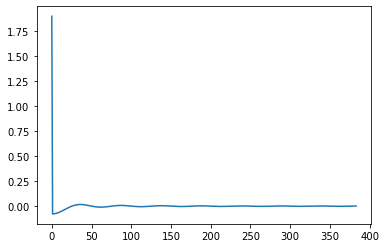

In [37]:
plt.plot(freq_weighting[4000,:Nfreqs])

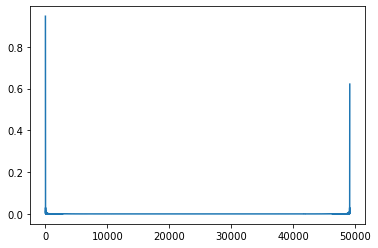

In [58]:
plt.plot(np.abs(freq_weighting[2000,:]))

In [ ]:
weight_mat = np.zeros((Nbls, Nfreqs, Nfreqs), dtype=complex)
for freq_ind1 in range(Nfreqs):
    for freq_ind2 in range(Nfreqs):
        weight_mat[:, freq_ind1, freq_ind2] = freq_weighting[
            :, np.abs(freq_ind1 - freq_ind2)
        ]

# Make normalization match identity matrix weight mat
normalization_factor = (
    Nfreqs * Nbls / np.sum(np.trace(weight_mat, axis1=1, axis2=2))
)
weight_mat *= normalization_factor